In [1]:
#v1 = vector((float(1), float(0)))             # 1    
#v2 = vector((float(-1/2), float(sqrt(3)/2)))  # omega
#v3 = vector((float(-1/2), float(-sqrt(3)/2))) # omega^2

#v1 = vector((2, 0))
#v2 = vector((-1, 3))
#v3 = vector((-1, -3))


v1 = vector((0, 2))
v2 = vector((-3, -1))
v3 = vector((3, -1))


def benzel_corners(a,b):
    return [
        a*v2 + b*v1,
        -a*v3 - b*v1,
        a*v3 + b*v2,
        -a*v1 - b*v2,
        a*v1 + b*v3,
        -a*v2 - b*v3
    ]

P = benzel_corners(4,6)


(0,0) in P

False

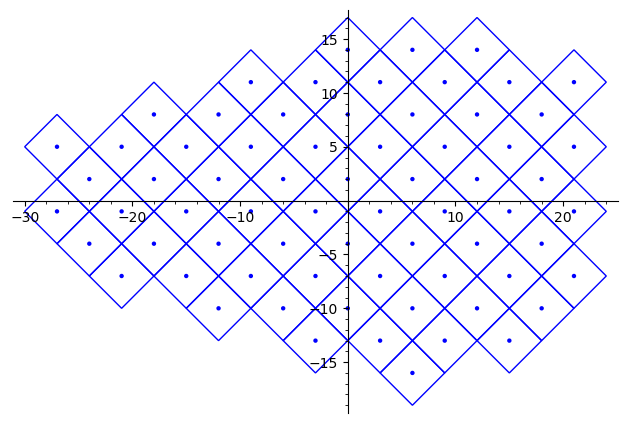

In [2]:
# takes in a and b from the (a,b)-benzel and returns the barycentric coordinates of said benzel
def benzel_cell_coords(a,b):
    c = max(a,b)
    result = set()
    # this range is too big, but not that much too big
    for i in range(-c, c+1):
        for j in range(-c, c+1):
            for k in range(-c, c+1):
                # these are the inequalities written by Jim in "20 Open Problems" 
                if (i+j+k==1 and 
                    -(a-1) <= j-i <= (b-1) and 
                    -(a-1) <= k-j <= (b-1) and 
                    -(a-1) <= i-k <= (b-1)
                   ):
                    result.add((i,j,k))
    return result


# returns the square centered at the given point p, taken in as a tuple
def square_centered_at(p):
    return [
        p + vector((3,0)),
        p + vector((0,+3)),
        p + vector((-3,0)),
        p + vector((0,-3)),
    ]

For the following functions, we used the fact that the table in "20 Open Problems" problem 5

$$\begin{array}{c|ccccccccc}
a\backslash b & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\\hline
2 & 1 \\
3 & & 0 & 1\\
4 & & 1 & 2 & 0 & 1\\
5 & & & 0 & 1 & 4 & 0 & 1\\
6 & & & 1 & 4 & 0 & 1 & 10 & 0 & 1\\
7 & & & & 0 & 1 & 8 & 0 & 1 & 28\\
8 & & & & 1 & 10 & 0 & 1 & 24 & 0 \\
9 & & & & & 0 & 1 & 24 & 0 & 1\\
10 & & & & & 1 & 28 & 0 & 1 & 48
\end{array}$$

The pattern happens in $(n + i, n + 2*i)$ stripes continuing diagonally down-down-right, starting at $(n,n)$. So for the rest of the notebook instead of using $(a,b)$-benzels, we use $n$ as our start value, and $i$ as our step value. 

In [3]:
# returns the centers for cells in the benzel with barycentric coordinates 
# (i,j,k) contained in an (a,b) benzel
def benzel(step, start=7):
    v1 = vector((0, 2))
    v2 = vector((-3, -1))
    v3 = vector((3, -1))
    shift = vector((3*step, 0))
    return [(v1*i + v2*j + v3 * k + shift) for (i,j,k) in benzel_cell_coords(start + step, start + 2*step)]

# works mod three the x-value of an input coordinate. Shifts horizontally toward the origin
def compress(p):
    x = p[0]//3
    if x<0:
        return p - ceil((x-1)/3) * vector((3,3))
    else:
        return p + floor((x+1)/3) * vector((-3, 3))

# performs compression on every third column on the center points of a benzel pattern
def compressed_benzel(step, start = 7):
    return [compress(p) for p in benzel(step, start = start)]

# draws the line segmets in the benzel picture
def benzel_segments(step, start = 7):    
    segments = set()
    for p in compressed_benzel(step, start = start):
        corners = [tuple(u) for u in square_centered_at(p)]
        for i in range(4):
            a = corners[i-1]
            b = corners[i]
            slope = (b[1]-a[1])/(b[0]-a[0])
            mx = (a[0] + b[0])             
            if mx < 0:
                if (mx % 12) != 3 or slope != -1:
                    segments.add((corners[i-1], corners[i]))
            elif mx > 0:
                if (mx % 12) != 9 or slope != 1:
                    segments.add((corners[i-1], corners[i]))
    return segments

def show_benzel(a, start = 4, save = False, compressed = False, axes = False, draw = True):
    if compressed:
        benzel_cells = compressed_benzel(a, start = start)
    else:
        benzel_cells = benzel(a, start = start)
    p = (
        sum(polygon(square_centered_at(p), fill = False) for p in benzel_cells) +
        points(benzel_cells)
    )
    if draw:
        p.show(aspect_ratio=1, axes = axes)
    if save:
        p.save_image(str(start+a) + "-" + str(start+2*a) + "benzel.svg", aspect_ratio = 1, axes = False)
    if not draw:
        return p

def benzel_dual_segments(a, start = 7):    
    segments = set()
    compressed_list = compressed_benzel(a, start = start)
    x_min, x_max = min(compressed_list)[0], max(compressed_list)[0]
    y_min, y_max = min(compressed_list)[1], max(compressed_list)[1]
    for p in compressed_list:
        if p[0] == 0:
            segments.add(((p[0] - 3, p[1] + 3), tuple(p)))
            segments.add(((p[0] + 3, p[1] + 3), tuple(p)))
            
        elif p[0] >= x_min and p[1] <= y_max:
            if p[0] < 0:
                segments.add(((p[0] + 3, p[1] + 3), tuple(p)))
                if p[0] % 2 == 0 and p[0] != x_min:
                    segments.add(((p[0] - 3, p[1] + 3), tuple(p)))
                    
            if p[0] > 0:
                segments.add(((p[0] - 3, p[1] + 3), tuple(p)))
                if p[0] % 2 == 0 and p[0] != x_max:
                    segments.add(((p[0] + 3, p[1] + 3), tuple(p)))
    return segments

def show_dual_benzel(a, start = 4, save = False, compressed = False, axes = False, draw = True, color = "blue"):
    
    p = sum(line(e, color = color) for e in benzel_dual_segments(a, start = start))
    if draw:
        p.show(aspect_ratio=1, axes = axes)
    if save:
        p.save_image(str(start+a) + "-" + str(start+2*a) + "dual_benzel.svg", aspect_ratio = 1, axes = axes)
    if not draw:
        return p

def aztec_bounds(a, start = 7):
    benzel_list = compressed_benzel(a, start)
    aztec_edges = set()
    for edge in benzel_list:
        aztec_edges.add(((edge[0][0], -edge[0][1]), (edge[1][0], -edge[1][1])))
        aztec_edges.add(edge)
    p = (
        sum(polygon(square_centered_at(p), fill = False) for p in benzel_cells) +
        points(benzel_cells)
    )
    return p

#aztec_bounds(2, 22).show()
    

# start + 2*a, start + a
start_num = 4
step = 2
#(show_benzel(step, start = start_num, compressed = True, draw = False) + show_dual_benzel(step, start = start_num, draw = False, color = "red")).show(axes = False)

#show_benzel(step, start = start_num, compressed = True)
#(show_dual_benzel(step, start = start_num, save=False, draw=False) + show_dual_benzel(step, start = start_num-6, save=False, color="red", draw=False)).show(aspect_ratio=1)
#aztec_bounds(step, start = start_num)

Animation with 51 frames
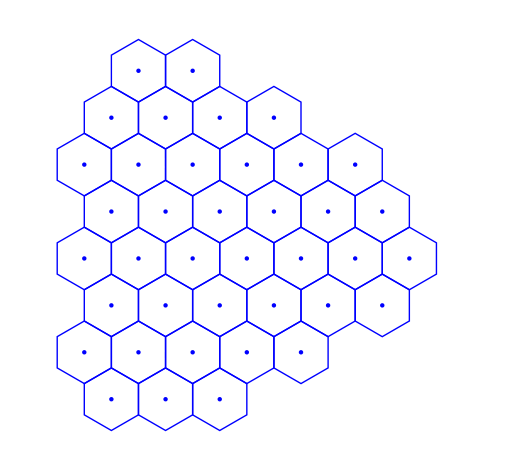

Animation saved to file /home/vidnel/Dropbox (University of Oregon)/leigh/benzels/squarified (8, 6)-benzel.gif.


[Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics object consisting of 40 graphics primitives,
 Graphics 

In [6]:
def hex_centered_at(p, time = 1):
    regular_hex = [
        p + vector((3*cos(pi/6),   3*sin(pi/6))),
        p + vector((3*cos(3*pi/6), 3*sin(3*pi/6))),
        p + vector((3*cos(5*pi/6), 3*sin(5*pi/6))),
        p + vector((3*cos(7*pi/6), 3*sin(7*pi/6))),
        p + vector((3*cos(9*pi/6), 3*sin(9*pi/6))),
        p + vector((3*cos(11*pi/6), 3*sin(11*pi/6))),
    ]
    regular_square = [
        p + vector((3,0)),
        p + vector((0,+3)),
        p + vector((-3,0)),
        p + vector((-3,0)),
        p + vector((0,-3)),
        p + vector((3,0)),
    ]
    if time == 1:
        return regular_hex
    else:
        return [(1-time) * regular_square[vertex] + time * regular_hex[vertex] for vertex in range(len(regular_hex))]

def desquare(a, start = 4, save = False, axes = False, draw = True):
    square_centers = benzel(a, start = start)
    hex_centers = [vector((((sqrt(3)/2))*vec[0], 1.5*vec[1])) for vec in square_centers]
    p = (
        sum(polygon(hex_centered_at(p), fill = False) for p in hex_centers) +
        points(hex_centers)
        )
    if draw:
        p.show(aspect_ratio=1, axes = axes)
    if save:
        p.save_image(str(start+a) + "-" + str(start+2*a) + "benzel.svg", aspect_ratio = 1, axes = False)
    if not draw:
        return p

def desquare_animation(step_val, start_val, time_interval, display = True, save = False):
    square_centers = benzel(step_val, start_val)
    hex_centers = [vector((((sqrt(3)/2))*vec[0], 1.5*vec[1])) for vec in square_centers]
    x_min = 99999
    y_min = 99999
    x_max = -99999
    y_max = -99999
    for center in square_centers:
        x_val = center[0]
        y_val = center[1]
        if x_val < x_min:
            x_min = x_val
        if x_val > x_max:
            x_max = x_val
        if y_val < y_min:
            y_min = y_val
        if y_val > y_max:
            y_max = y_val

    time = [sec/time_interval for sec in range(time_interval+1)]
    anim_dict = {} # this is the animation over time for just the centers
    whole_shebang = []
    for frame in time:
        final_centers_at_frame = [(1-frame) * square_centers[center_index] + frame * hex_centers[center_index] for center_index in range(len(square_centers))]
        anim_dict[frame] = final_centers_at_frame
    
        p = (
            sum(polygon(hex_centered_at(p, frame), fill = False) for p in final_centers_at_frame) +
            points(final_centers_at_frame)
        )
#        p.show(axes = False)
        whole_shebang.append(p)
    whole_shebang.reverse()
    if display == True:
        animate(whole_shebang, aspect_ratio = 1, axes = False, xmin = x_min-5, xmax = x_max+5, ymin = 1.5*y_min-5, ymax = 1.5*y_max+5).show()
    if save == True:
        animate(whole_shebang, aspect_ratio = 1, axes = False, xmin = x_min-5, xmax = x_max+5, ymin = 1.5*y_min-5, ymax = 1.5*y_max+5).save("squarified ({a}, {b})-benzel.gif".format(a = start_val + 2*step_val, b = start_val + step_val), show_path = True)
    return whole_shebang 

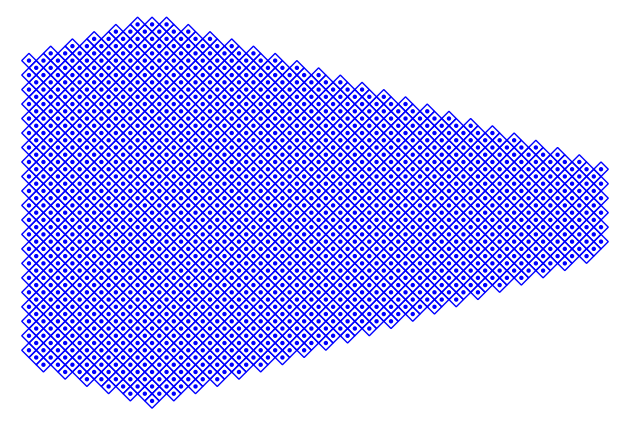

In [5]:
def graphics_to_tikz(graphic, write_out = False):
    output = ''
    graphic_list = graphic.description().split("\n") # the graphics description is now split by new line

    for line in graphic_list: # iterate over the lines in the graphics description
        line_list = line.split("\t") # separates out the line into before and after the tab
        points_string = line_list[1]
        points_list = points_string[1:-1].split("(")
        first_word = line_list[0].split()[0]
        if first_word == "Line":
            first_vert = points_list[1]
            second_vert = points_list[2]
            output += "\n" + "\\draw ({first}) -- ({second});".format(first = first_vert[0:first_vert.index(")")], second = second_vert[0:second_vert.index(")")])
        elif first_word == "Polygon":
            first_vertex = points_list[1]
            output += "\n" + "\\draw "
            for vertex in points_list:
                if len(vertex) != 0:
                    ind = vertex.index(")")
                    output += "({x}) -- ".format(x = vertex[0:ind])
            ind = first_vertex.index(")")
            output += "({x});".format(x = first_vertex[0:ind])
        elif first_word == "Point":
            for vertex in points_list:
                if len(vertex) != 0:
                    ind = vertex.index(")")
                    output += "\n" + "\\node at ({x}) {{$\\bullet$}};".format(x = vertex[0:ind])
        else:
            print("Make this a real breaks things error saying that we don't know how to draw that")
    return output

benz = show_benzel(15, start = 18, draw = False, compressed = False, save = False)
show_benzel(15, start = 18, draw = True, compressed = False, save = False)


with open("benzel_tikz.txt", "w") as text_file:
    text_file.write(graphics_to_tikz(benz))
# lines are split by \n
# beginning of a set of points is preceded by \t

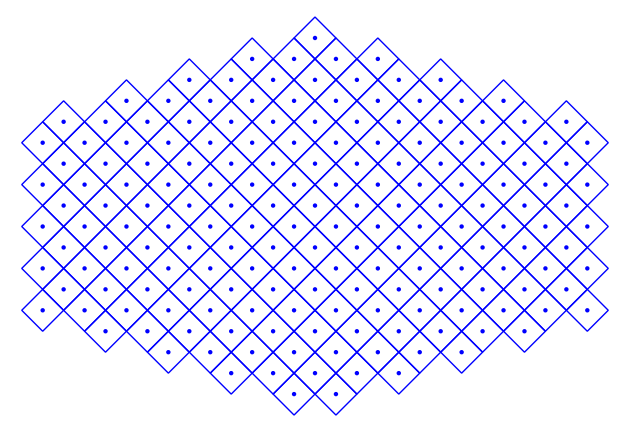

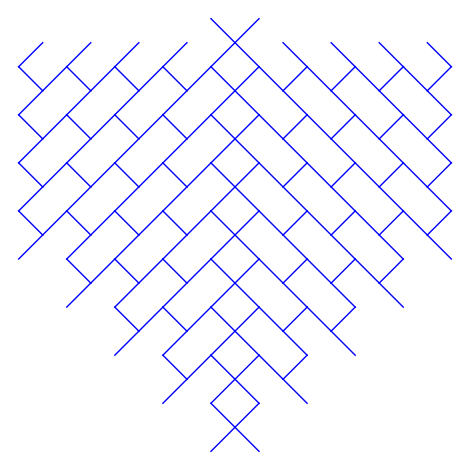

In [5]:
show_benzel(0, start = 14, draw = True, compressed = False, save = False)
show_dual_benzel(0, start = 14, save = False, draw = True)

7 7


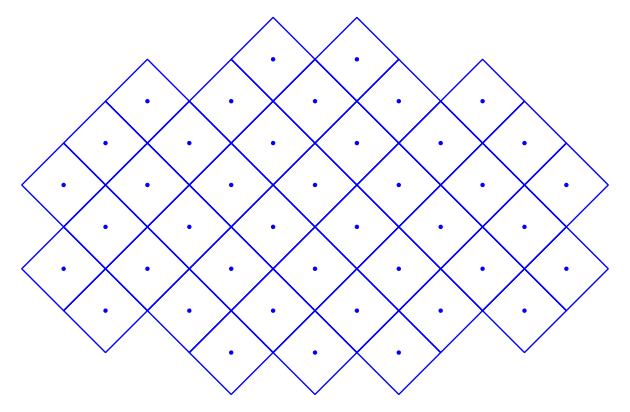

8 9


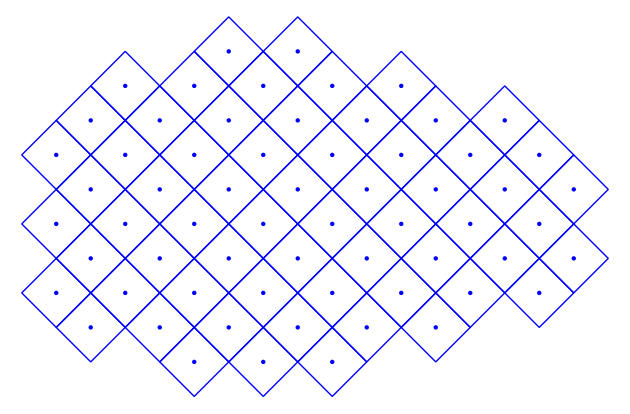

9 11


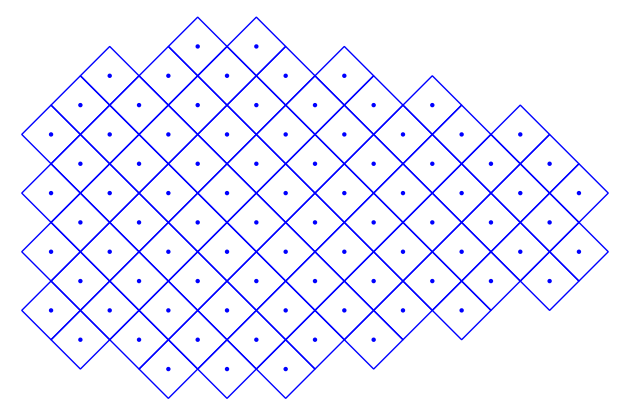

10 13


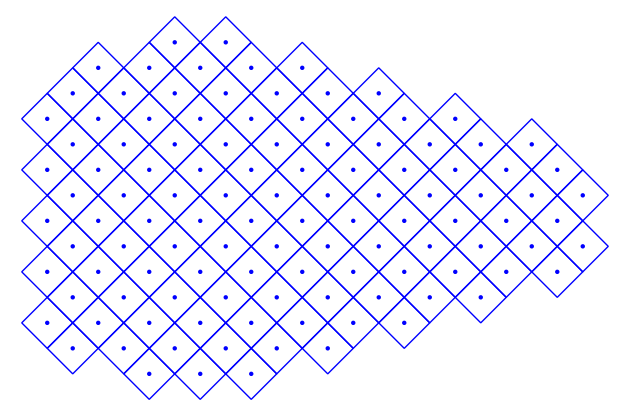

11 15


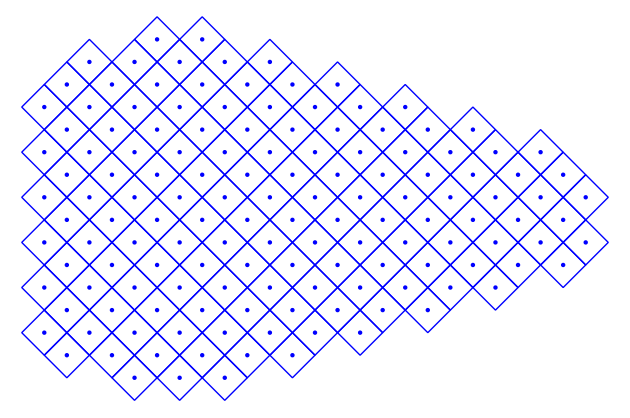

12 17


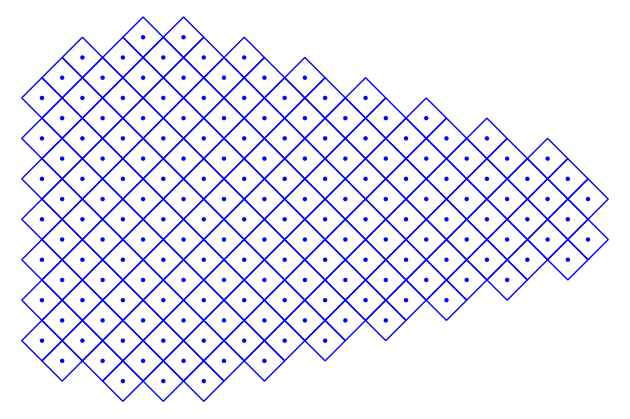

13 19


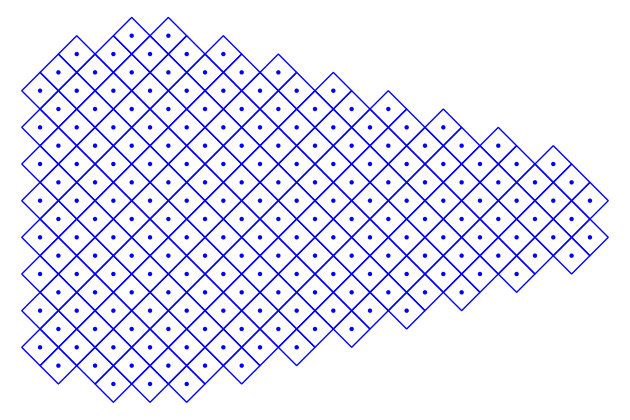

14 21


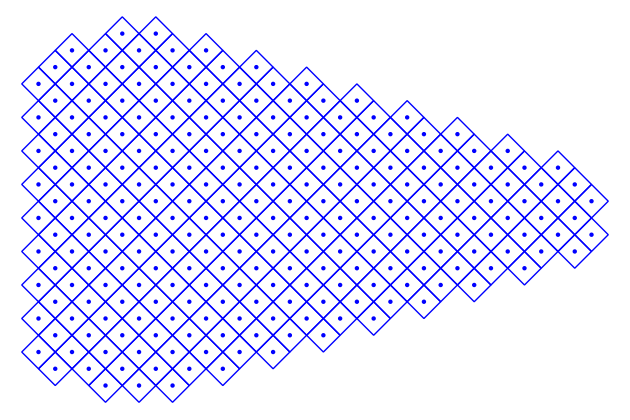

In [6]:
start = 7
for a in range(8):
    benzel_cells = [(v1*i + v2*j + v3 * k) for (i,j,k) in benzel_cell_coords(start + a, start + 2*a)]

    print(start+a, start+2*a)
    p = (
        sum(polygon(square_centered_at(p), fill = False) for p in benzel_cells) +
        points(benzel_cells)
    )
    p.show(aspect_ratio=1, axes = False)
#    p.save_image("start-"+str(start)+"/"+str(start+2*a) + "-" + str(start+a) + "benzel.png", aspect_ratio = 1, axes = False)

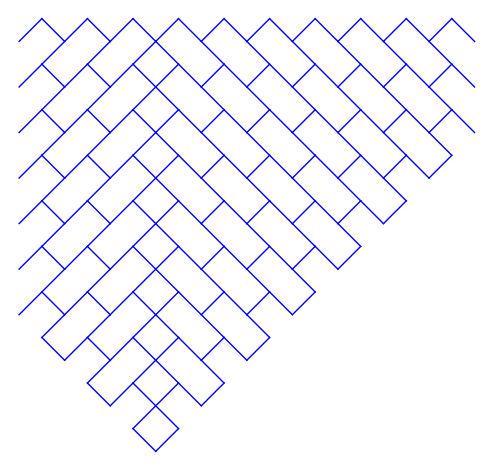

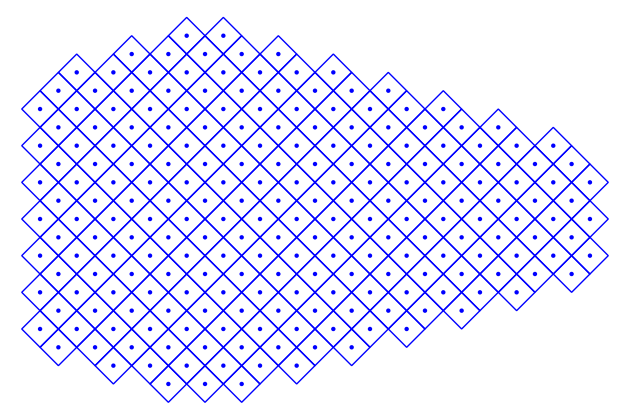

In [8]:
first = 4
second = 10

show_dual_benzel(first, second, save = True)
show_benzel(first, second, save = True)